In [107]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [108]:
# Load the data
train_data = pd.read_csv("data/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [109]:
test_data = pd.read_csv("data/test.csv")
# test_data.head()

In [110]:
# Data cleaning 

missing_values_count = train_data.isnull().sum()
# Col: Cabin 687/891, Age 177/891

total_cells = np.product(train_data.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print("Percent of missing values before: ", percent_missing)

# Drop Cabin column from train dataset
train_data = train_data.drop(columns=['Cabin'])

# New percent of missing values
new_missing_values_count = train_data.isnull().sum()
total_cells = np.product(train_data.shape)
total_missing = new_missing_values_count.sum()

new_percent_missing = (total_missing/total_cells) * 100
print("Percent of missing values after: ", new_percent_missing)

Percent of missing values before:  8.099513655069211
Percent of missing values after:  1.826344250586675


In [111]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [112]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


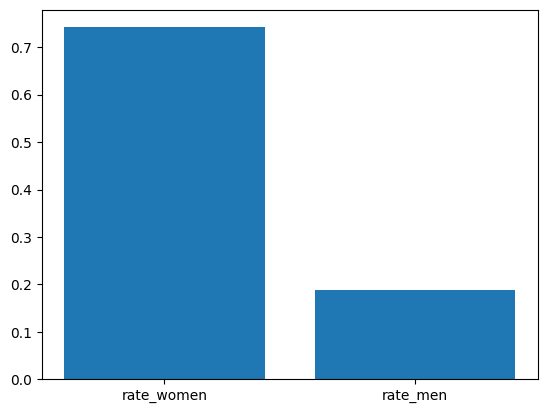

In [113]:
# Create plot for rate women and rate men
data = {'rate_women': rate_women, 'rate_men': rate_men}
names = list(data.keys())
values = list(data.values())

plt.bar(names, values)
plt.title("")
plt.show()

In [114]:
counted_embarked = test_data['Embarked'].value_counts()
print(counted_embarked)

plt.show()

Embarked
S    270
C    102
Q     46
Name: count, dtype: int64


In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]

X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print(output)

print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
Your submission was successfully saved!


In [116]:
# Analyze results

results = pd.read_csv('submission.csv')
results.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
